In [704]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append('../src')

In [705]:
from models.layers import NestedDropout
from models.cmpnts import MLP, SNMLP
from models.layers import SNLinearCombo
from torch.linalg import svd

# Optimizer

In [706]:
class LeastVolumeBinarySearch:
    """
    recursively find the optimal Lagrangian multiplier 
    by solving the concave dual problem with binary search.
    """
    def __init__(self, encoder, decoder, vol_func, rec_loss, eps, infL_optimizer, threshold=0.05, init_lambda=100):
        self.encoder = encoder
        self.decoder = decoder
        
        self.vol_func = vol_func
        self.rec_loss = rec_loss
        self.eps = eps
        self.threshold = threshold
        self.infL_optimizer = infL_optimizer

        assert init_lambda > 0, 'λ should be positive!'
        self.lamb = init_lambda if init_lambda > 0 else 1 
        self._n = 0
        self._lamb_min = self._lamb_max = None
    
    def optimize(self, max_iter=500, verbose=False):
        """
        optimize dual problem, return is_converged, 
        lambda, volume and reconstruction loss.
        """
        #### update lambda ####
        self.update_lamb()

        #### derive inf L ####
        self.encoder.train(); self.decoder.train()
        L = lambda: self.vol_func() - self.lamb * (self.eps - self.rec_loss())
        self.infL_optimizer(L) # should have a convergence criterion
        self.encoder.eval(); self.decoder.eval()
        #### report ####
        if verbose: self.report()
        
        #### determine convergence ####
        if self.residual >= 0:
            self._lamb_max = self.lamb
            if self._lamb_converged or True: # or ((self.residual/self.eps) <= self.threshold): # end recursion if is converged
                return True, self.lamb, self.vol_func(), self.rec_loss()
        else:
            self._lamb_min = self.lamb

        #### continue, or end recursion if n > max_iter ####
        self._n += 1
        if self._n >= max_iter: 
            return False, self.lamb, self.vol_func, self.rec_loss  
        else:
            return self.optimize(max_iter, verbose)
    
    @property
    def residual(self):
        """constraint is satisfied when it's >= 0"""
        return self.eps - self.rec_loss()
    
    @property
    def _lamb_converged(self):
        if self._lamb_max and self._lamb_min:
            return (self._lamb_max - self._lamb_min) / self._lamb_max < 1e-4
        else:
            return False
    
    def update_lamb(self):
        if self._lamb_min and self._lamb_max:
            self.lamb = (self._lamb_max + self._lamb_min) / 2
        elif self._lamb_min and not self._lamb_max:
            self.lamb = 2 * self._lamb_min
        elif self._lamb_max and not self._lamb_min:
            self.lamb = 0.5 * self._lamb_max
        else:
            pass
    
    def report(self):
        print('Iter #{}: λ = {}, obj = {:.3e}, residual = {:.3e} = {:.2%} × eps'.format(
            self._n, self.lamb, self.vol_func(), self.residual, self.residual/self.eps))

# Data

C:\Users\geniu\AppData\Local\Temp\ipykernel_141296\2300398846.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


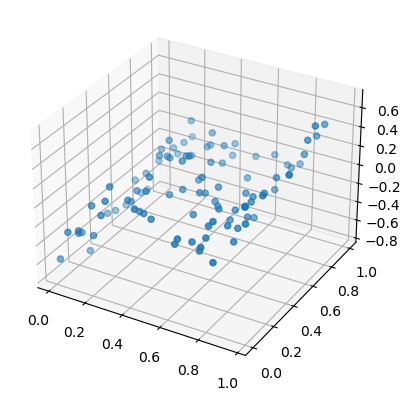

In [707]:
# X, _ = torch.sort(torch.rand(50))
# X = X - 0.5
# # Y = X + 5 * X ** 3 
# Y = 10 * (X - 0.4) * X * (X + 0.35)
# data = torch.stack([X, Y], dim=-1)

# plt.scatter(X.numpy(), Y.numpy())
# plt.show()

XY = torch.rand(100, 2)
X = XY[:, 0] - 0.5
Z = 10 * (X-0.3) * X * (X+0.3) + torch.randn(len(X))/10
data = torch.stack([XY[:,0], XY[:,1], Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
fig.show()

# Train

In [708]:
# encoder = MLP(2, 2, [32]*4)
# decoder = SNMLP(2, 2, [32]*4)
encoder = MLP(3, 3, [128]*4)
decoder = SNMLP(3, 3, [128]*4)
None

In [709]:
def vol():
    z = encoder(data)
    v = torch.exp(torch.log(z.std(0)).mean())
    return v

def vol2():
    z = encoder(data)
    v = torch.norm(z.std(0), p=1)
    return v

def vol3():
    z = encoder(data)
    v = torch.norm(z.std(0), p=2)
    return v

def rec_loss():
    z = encoder(data)
    rl = F.mse_loss(decoder(z), data) 
    return rl

In [710]:
def f_optimizer(loss_func, max_iter=20000, wait_n=500, verbose=False, epsilon=1e-2):
    opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)
    loss_his = []
    for i in range(max_iter):
        opt.zero_grad()
        loss = loss_func()
        loss.backward()
        opt.step()
        loss_his.append(loss.detach())
        if verbose and i % 10 == 0:
             print('Epoch {}: loss = {}'.format(i, loss))
        if len(loss_his) >= wait_n:
            last_his = torch.as_tensor(loss_his[-wait_n:])
            ratio = last_his.std() / (last_his.mean() + 1e-5)
            if ratio < epsilon:
                break
    print('L is converged at epoch {} with std/mean = {:.2%} over the last {} iterations.'.format(i, ratio, wait_n))

In [711]:
# loss_func = lambda: rec_loss() + 0.1 * vol()
# f_optimizer(loss_func)

In [712]:
searcher = LeastVolumeBinarySearch(encoder, decoder, vol, rec_loss, eps=1e-3, infL_optimizer=f_optimizer, threshold=0.20, init_lambda=10)
# searcher = LeastVolumeBinarySearch(encoder, decoder, vol2, rec_loss, eps=1e-3, infL_optimizer=f_optimizer, threshold=0.20, init_lambda=100)
# searcher = LeastVolumeBinarySearch(encoder, decoder, vol3, rec_loss, eps=5e-7, infL_optimizer=f_optimizer, threshold=0.20, init_lambda=100)
is_converged, lamb_, vol_, rec_ = searcher.optimize(verbose=True)

L is converged at epoch 549 with std/mean = 0.96% over the last 500 iterations.
Iter #0: λ = 10, obj = 7.483e-05, residual = -7.391e-02 = -7390.55% × eps
L is converged at epoch 19999 with std/mean = 5.96% over the last 500 iterations.
Iter #1: λ = 20, obj = 1.501e-02, residual = -3.427e-03 = -342.67% × eps
L is converged at epoch 19999 with std/mean = 10.99% over the last 500 iterations.
Iter #2: λ = 40, obj = 1.543e-02, residual = -1.689e-03 = -168.87% × eps
L is converged at epoch 19999 with std/mean = 10.32% over the last 500 iterations.
Iter #3: λ = 80, obj = 2.514e-02, residual = -1.024e-03 = -102.39% × eps
L is converged at epoch 19999 with std/mean = 10.07% over the last 500 iterations.
Iter #4: λ = 160, obj = 1.969e-02, residual = -6.922e-04 = -69.22% × eps
L is converged at epoch 19999 with std/mean = 7.37% over the last 500 iterations.
Iter #5: λ = 320, obj = 3.490e-02, residual = -5.174e-04 = -51.74% × eps
L is converged at epoch 19999 with std/mean = 11.34% over the last 5

In [713]:
searcher._lamb_max, searcher._lamb_min, searcher.lamb, searcher.rec_loss().item()

(2560, 1280, 2560, 0.0009549668175168335)

In [714]:
searcher._lamb_converged or ((searcher.residual/searcher.eps) <= searcher.threshold)

tensor(True)

In [715]:
searcher.residual, searcher.rec_loss(), searcher.eps

(tensor(4.5033e-05, grad_fn=<RsubBackward1>),
 tensor(0.0010, grad_fn=<MseLossBackward0>),
 0.001)

# Evaluate

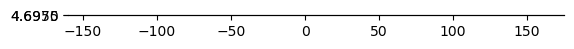

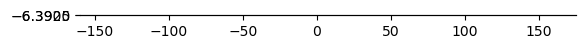

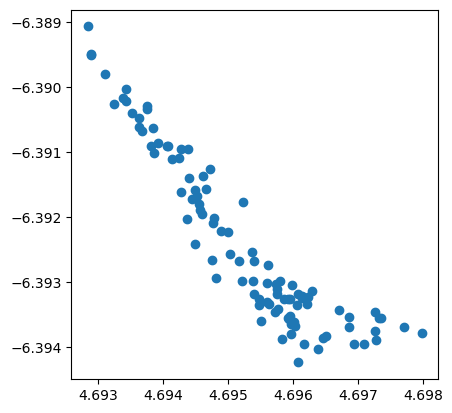

In [716]:
# encoder.eval()
# decoder.eval()

# z = encoder(data)
# plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
# plt.gca().set_aspect('equal')
# plt.show()

encoder.eval()
decoder.eval()

z = encoder(data)

plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,1].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [717]:
z.max(0)[0] - z.min(0)[0]

tensor([3.0455e+02, 5.1360e-03, 5.1703e-03], grad_fn=<SubBackward0>)

In [718]:
z.T.cov()

tensor([[ 2.9350e+03,  6.1089e-02, -5.9637e-02],
        [ 6.1089e-02,  1.4286e-06, -1.4581e-06],
        [-5.9637e-02, -1.4581e-06,  1.7309e-06]], grad_fn=<SqueezeBackward0>)

C:\Users\geniu\AppData\Local\Temp\ipykernel_141296\101479559.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


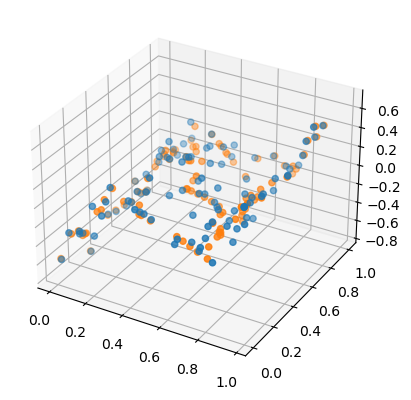

In [719]:
# rec = decoder(z).detach().numpy()
# plt.scatter(X.numpy(), Y.numpy())
# plt.scatter(rec[:, 0], rec[:, 1])

rec = decoder(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

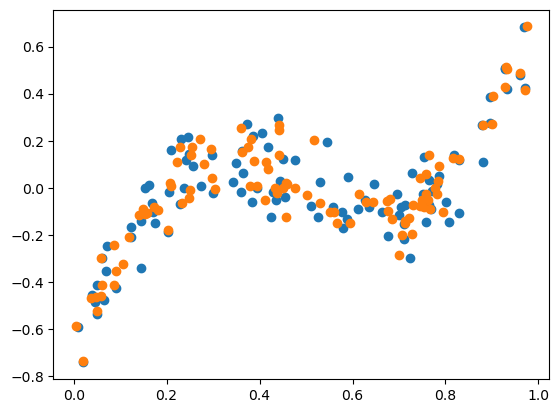

In [720]:
plt.scatter(XY[:,0].numpy(), Z.numpy())
plt.scatter(rec[:, 0], rec[:, 2])
plt.show()